# Neural networks basics

## Starting with simple pixel-distance to get a hang of working with images as tensors

Load training data for 3s and 7s

In [190]:
from fastai.vision.all import *

datapath = Path('C:/Users/marcinzi/.fastai/data/mnist_sample')

train_3s = (datapath/'train'/'3').ls()[:100]
train_7s = (datapath/'train'/'7').ls()[:100]

example_3_img = Image.open(train_3s[8])
example_3_tensor = tensor(example_3_img)/255
example_7_tensor = tensor(Image.open(train_7s[5]))/255

In [191]:
def show_2d_tensor(t):
    df = pd.DataFrame(t)
    return df.style.set_properties(**{'font-size': '5pt'}).background_gradient('Greys')

im3t = tensor(example_3_img)
show_2d_tensor(im3t)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,51,159,253,253,253,255,253,253,159,113,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,238,252,252,252,252,253,252,252,252,252,163,134,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,253,233,195,102,55,56,103,195,233,252,253,167,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,146,148,0,0,0,0,0,0,169,252,253,167,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,215,252,253,89,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,222,253,253,204,15,0,0,0,0,0,0,0


Generate an average (mean) "3"

<Axes: >

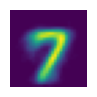

In [192]:
tensors_3s = [tensor(Image.open(o)) for o in train_3s]
stacked_3s = torch.stack(tensors_3s).float()/255

tensors_7s = [tensor(Image.open(o)) for o in train_7s]
stacked_7s = torch.stack(tensors_7s).float()/255

mean_3 = stacked_3s.mean(0)
mean_7 = stacked_7s.mean(0)

#show_2d_tensor(mean_3)
show_image(mean_7)

Calculating loss, i.e. distance from avegare 3 to example 3,
using L1 and L2 (MSE) losses.

In [46]:
L1 = F.l1_loss(example_3_tensor, mean_3)
MSE = F.mse_loss(example_3_tensor, mean_3).sqrt()

L1, MSE

(tensor(0.1101), tensor(0.2157))

Now we need the distance function

In [ ]:
def distance_abs(t1, t2): return (t1 - t2).abs().mean((-1,-2))   # take mean over last and 2nd last index of the tensor, i.e. produce tensor on the first index

def is_3(t): return distance_abs(t, mean_3) < distance_abs(t, mean_7)

is_3(example_3_tensor), is_3(example_7_tensor)

(tensor(True), tensor(False))

Now we take valid images, and calculate human-friendly metric - accuracy

In [193]:
valid_3s = (datapath/'valid'/'3').ls()[:10]
valid_3s_img = [Image.open(o) for o in valid_3s]
valid_3s_tstack = torch.stack([tensor(o) for o in valid_3s_img]).float()/255

valid_7s = (datapath/'valid'/'7').ls()[:10]
valid_7s_img = [Image.open(o) for o in valid_7s]
valid_7s_tstack = torch.stack([tensor(o) for o in valid_7s_img]).float()/255

accuracy_3s = is_3(valid_3s_tstack).float().mean()
accuracy_7s = (1- is_3(valid_7s_tstack).float()).mean()

accuracy_3s, accuracy_7s

(tensor(0.8000), tensor(1.))

## Stochastic Gradient Descent (SGD)

### Raw SGD implementation

I will be looking to approximate a pre-generated data, looking like a quadratic function with some noise.

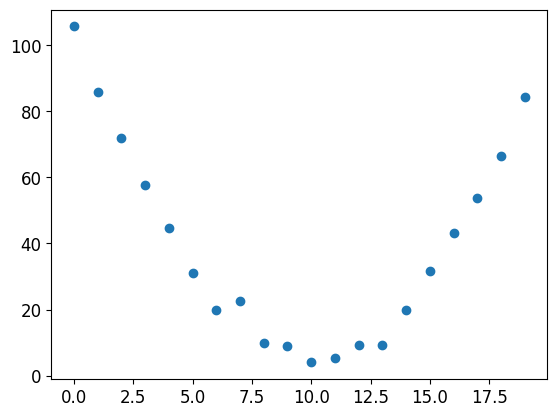

In [93]:
from fastbook import *

time = torch.arange(0,20).float()
speed = (time-10)**2 + 5 + torch.randn(20)*3 

def plot(time, expected, actual=None):
    chart = plt.subplots()[1]
    chart.scatter(time, expected)
    if actual is not None: chart.scatter(time, actual, color='red')

plot(time, speed)

Basics of SGD - fitting quadratic function

1. define model as simple quadratic function  :   f(x) = a*x^2 + b*x + c
1. define mean-squared-error loss function
1. intialize random weights - a, b, c,   enable torch gradient tracking
1. run function / predict from model using current weights
1. calculate loss
1. go backward from loss to find out a,b,c gradients influence on loss
1. modify weights a,b,c   in tiny proportion called Learning Rate  and clear gradients
1. repeat

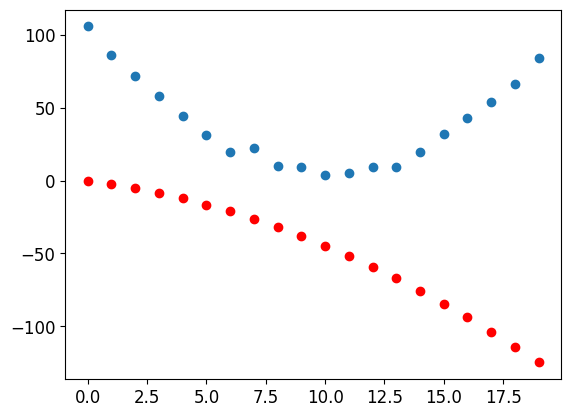

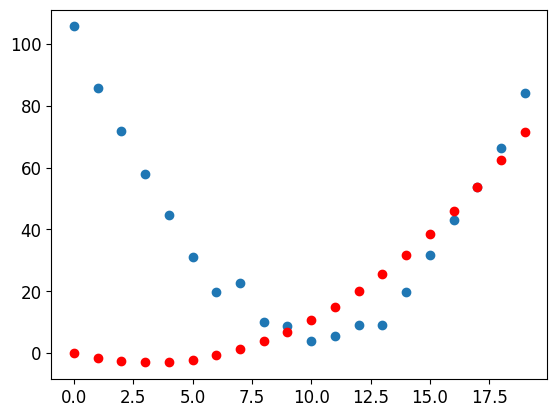

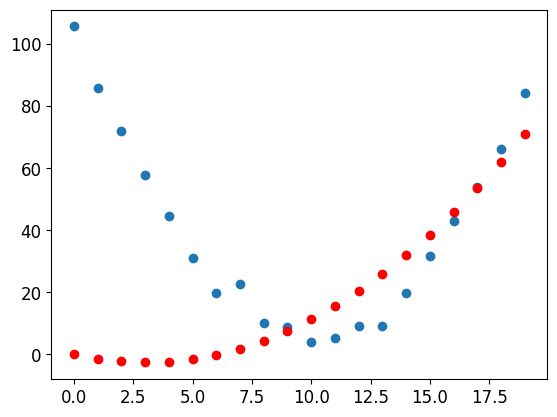

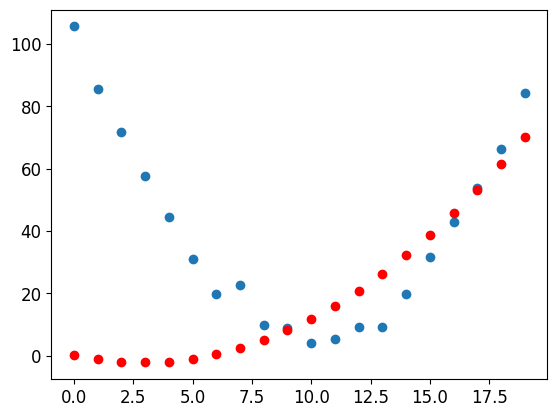

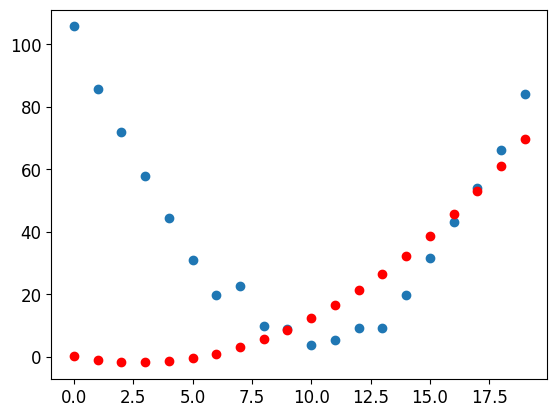

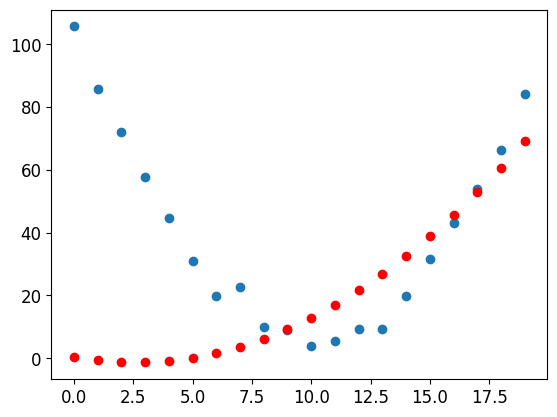

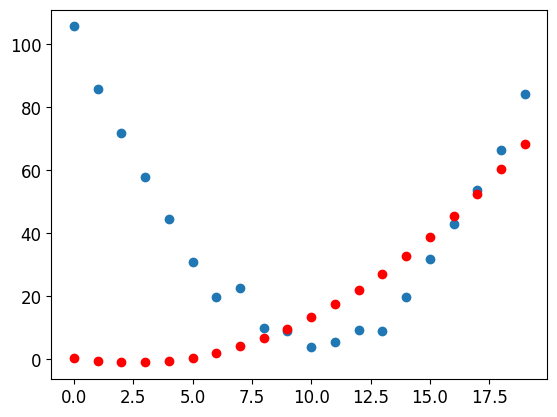

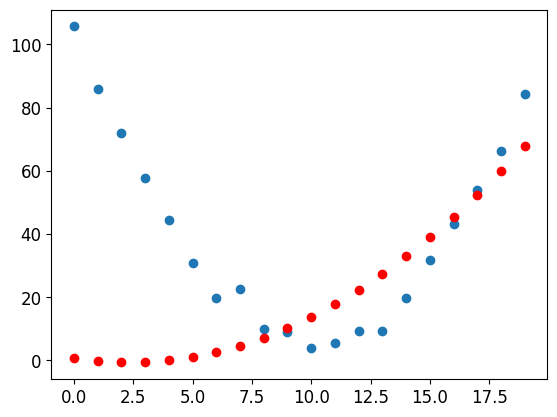

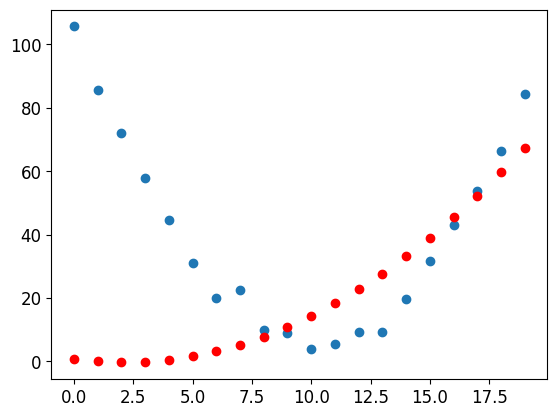

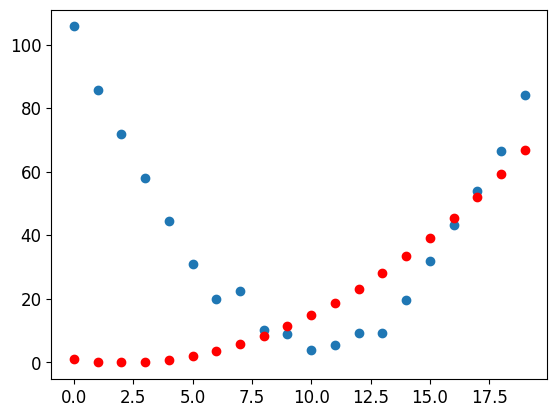

In [117]:
def quad(x, params) : 
    a, b, c = params
    return a*x**2 + b*x + c

def mse_loss(preds, targets): 
    return ((preds - targets)**2).mean().sqrt()

#1 init params
params = torch.randn(3).requires_grad_()


lr = 0.00002
for epoch in range(100000):
    #2 calc preds
    preds = quad(time, params)

    #3 calc loss
    loss = mse_loss(preds, speed)

    #print(loss.item())

    #4 step weights
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None

    if epoch % 10000 == 0:
        plot(time, speed, to_np(preds))




### Raw SGD on pixel-matrices

Prepare (needs to be run ahead of every approach following)

- taking 100 3s and 100 7s from training set, and zipping into tuples (tensor, label)
- label is 1 for 3s, and 0 for 7s
- intializing random weights and bias,   and taking matrix multiplication function (linear model)
- loss fuction is distance to expected 0 or 1, normalized

In [198]:
def init_params(size):
    return torch.randn(size).requires_grad_()

train_x = torch.cat([stacked_3s, stacked_7s]).view(-1, 28*28)
train_y = tensor([1]*len(stacked_3s) + [0]*len(stacked_7s)).unsqueeze(1)
train_dset = list(zip(train_x, train_y))


valid_x = torch.cat([valid_3s_tstack, valid_7s_tstack]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3s_tstack) + [0]*len(valid_7s_tstack)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))

weights = init_params(28*28)
bias = init_params(1)

def linear1(xb): 
    return xb@weights + bias


def loss(prd, trgt):
    prd = prd.sigmoid()
    return torch.where(trgt==1, 1-prd, prd).mean()

In [181]:
predictions = linear1(train_x)
loss(predictions, train_y)

tensor(0.5000, grad_fn=<MeanBackward0>)

Manual approach

In [195]:
dl = DataLoader(train_dset)
valid_dl = DataLoader(valid_dset)

def calc_grad(xb, yb, f):
    preds = f(xb)
    l = loss(preds, yb)
    l.backward()

def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= lr * p.grad.data
            p.grad.zero_()

def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    return ((preds>0.5)==yb).float().mean()

def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

lr = 1
params = weights, bias
for i in range(15):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1))

0.5
0.75
0.85
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95
0.95


Wrapped in learner with linear model

In [197]:
dl = DataLoader(train_dset)
valid_dl = DataLoader(valid_dset)
dls = DataLoaders(dl, valid_dl)

learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=loss, metrics=batch_accuracy)

learn.fit(20, lr=1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.413642,0.432718,0.550000,00:00
1,0.020927,0.414947,0.600000,00:00
2,0.013678,0.358791,0.650000,00:00
3,0.010261,0.217879,0.750000,00:00
4,0.006933,0.109097,0.900000,00:00
5,0.001052,0.050187,0.950000,00:00
6,0.000625,0.050192,0.950000,00:00
7,0.000616,0.050198,0.950000,00:00
8,0.000613,0.050202,0.950000,00:00
9,0.000608,0.050206,0.950000,00:00


Wrapped in learner with simple neural network
input (28x28) -> 30 -> ReLU -> 1

In [199]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=loss, metrics=batch_accuracy)

learn.fit(20, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.102071,0.487656,0.500000,00:00
1,0.021355,0.370402,0.600000,00:00
2,0.010670,0.209533,0.850000,00:00
3,0.005991,0.116986,0.900000,00:00
4,0.004985,0.081829,0.950000,00:00
5,0.004171,0.064695,0.950000,00:00
6,0.003841,0.060529,0.950000,00:00
7,0.002841,0.055602,0.950000,00:00
8,0.001776,0.053845,0.950000,00:00
9,0.001187,0.053769,0.950000,00:00
